# 🤖 Robot Odometry Trajectory Analysis

Simple and clean analysis of robot trajectories from ROS2 odometry data.

### Data Sources:
- **Odometry**: `/robomaster/odom` (position and velocities)
- **IMU**: `/robomaster/imu` (orientation data)

### Analysis Output:
- 2D trajectory visualization
- Position and orientation over time
- Movement statistics

In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# ROS2 bag reading with rosbags library (pure Python, no ROS required)
try:
    from rosbags.rosbag2 import Reader
    from rosbags.serde import deserialize_cdr
    print("✅ rosbags library loaded (pure Python)")
except ImportError:
    print("❌ rosbags library not found!")
    print("Install with: pip install rosbags")

# Configure plotting
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 11
plt.style.use('default')

print("🤖 Ready for odometry analysis!")

✅ rosbags library loaded (pure Python)
🤖 Ready for odometry analysis!


In [25]:
# Configuration - Update your bag file path
# BAG_FILE = "experiment_bags/exp_pregassona_1_2025-09-13T07-16-09-907Z"
BAG_FILE = "experiment_bags/exp_pregassona_2_2025-09-13T07-36-14-321Z"

# Verify bag exists
if os.path.exists(BAG_FILE):
    print(f"✅ Bag found: {BAG_FILE}")
else:
    print(f"❌ Bag not found: {BAG_FILE}")
    print("Update BAG_FILE path above")

print("\n📊 Expected topics:")
print("   • /robomaster/odom (odometry data)")
print("   • /robomaster/imu (orientation)")

✅ Bag found: experiment_bags/exp_pregassona_2_2025-09-13T07-36-14-321Z

📊 Expected topics:
   • /robomaster/odom (odometry data)
   • /robomaster/imu (orientation)


In [26]:
# Read odometry data from bag
def read_odometry_data(bag_path):
    """Extract odometry data from ROS2 bag using rosbags library"""
    if not os.path.exists(bag_path):
        return []
    
    odom_data = []
    
    try:
        with Reader(bag_path) as reader:
            # Filter for odometry topic
            connections = [x for x in reader.connections if x.topic == '/robomaster/odom']
            
            if not connections:
                print("❌ No /robomaster/odom topic found in bag")
                return []
            
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                # Deserialize the message
                odom_msg = deserialize_cdr(rawdata, connection.msgtype)
                
                # Extract position
                x = odom_msg.pose.pose.position.x
                y = odom_msg.pose.pose.position.y
                
                # Extract orientation (quaternion to yaw)
                qx = odom_msg.pose.pose.orientation.x
                qy = odom_msg.pose.pose.orientation.y
                qz = odom_msg.pose.pose.orientation.z
                qw = odom_msg.pose.pose.orientation.w
                yaw = np.arctan2(2.0 * (qw * qz + qx * qy), 1.0 - 2.0 * (qy * qy + qz * qz))
                
                # Extract velocities
                vx = odom_msg.twist.twist.linear.x
                vy = odom_msg.twist.twist.linear.y
                wz = odom_msg.twist.twist.angular.z
                
                odom_data.append({
                    'timestamp': timestamp / 1e9,  # Convert nanoseconds to seconds
                    'x': x,
                    'y': y,
                    'yaw': yaw,
                    'yaw_deg': np.degrees(yaw),
                    'vx': vx,
                    'vy': vy,
                    'wz': wz,
                    'speed': np.sqrt(vx*vx + vy*vy)
                })
                
    except Exception as e:
        print(f"❌ Error reading odometry: {e}")
        return []
    
    print(f"✅ Read {len(odom_data)} odometry points")
    return odom_data

print("✅ Odometry reader ready")

✅ Odometry reader ready


In [27]:
# Read event data from bag
def read_event_data(bag_path):
    """Extract event data from ROS2 bag using rosbags library"""
    if not os.path.exists(bag_path):
        return []
    
    event_data = []
    
    try:
        with Reader(bag_path) as reader:
            # Filter for experiment event topic
            connections = [x for x in reader.connections if x.topic == '/experiment/event']
            
            if not connections:
                print("⚠️ No /experiment/event topic found in bag")
                return []
            
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                try:
                    # Deserialize the message
                    event_msg = deserialize_cdr(rawdata, connection.msgtype)
                    
                    # Parse event message (assuming it's a JSON string in std_msgs/String)
                    if hasattr(event_msg, 'data'):
                        import json
                        try:
                            event_json = json.loads(event_msg.data)
                            event_data.append({
                                'timestamp': timestamp / 1e9,  # Convert nanoseconds to seconds
                                'event_type': event_json.get('event_type', 'unknown'),
                                'action': event_json.get('action', 'unknown'),
                                'details': event_json.get('details', {}),
                                'session_id': event_json.get('session_id', '')
                            })
                        except json.JSONDecodeError:
                            # If not JSON, treat as plain string
                            event_data.append({
                                'timestamp': timestamp / 1e9,
                                'event_type': 'raw_message',
                                'action': 'message',
                                'details': {'message': event_msg.data},
                                'session_id': ''
                            })
                            
                except Exception as e:
                    print(f"⚠️ Error parsing event message: {e}")
                    continue
                
    except Exception as e:
        print(f"❌ Error reading events: {e}")
        return []
    
    print(f"✅ Read {len(event_data)} event messages")
    return event_data

# Alternative: Read from JSONL file if bag reading fails
def read_event_data_from_jsonl(bag_path):
    """Fallback: read events from JSONL file"""
    import json
    from pathlib import Path
    
    # Try to find matching JSONL file
    bag_name = Path(bag_path).name
    jsonl_path = Path(bag_path).parent.parent / "experiment_logs" / f"{bag_name}.jsonl"
    
    if not jsonl_path.exists():
        print(f"⚠️ No JSONL file found at: {jsonl_path}")
        return []
    
    event_data = []
    try:
        with open(jsonl_path, 'r') as f:
            for line in f:
                if line.strip():
                    event_json = json.loads(line.strip())
                    # Convert ISO timestamp to Unix timestamp
                    from datetime import datetime
                    iso_time = event_json.get('timestamp', '')
                    unix_time = datetime.fromisoformat(iso_time.replace('Z', '+00:00')).timestamp()
                    
                    event_data.append({
                        'timestamp': unix_time,
                        'event_type': event_json.get('event_type', 'unknown'),
                        'action': event_json.get('action', 'unknown'),
                        'details': event_json.get('details', {}),
                        'session_id': event_json.get('session_id', '')
                    })
    except Exception as e:
        print(f"❌ Error reading JSONL: {e}")
        return []
        
    print(f"✅ Read {len(event_data)} events from JSONL file")
    return event_data

print("✅ Event data readers ready")

✅ Event data readers ready


In [28]:
# Load and analyze odometry data
print("🔄 Loading odometry data...")

odom_data = read_odometry_data(BAG_FILE)

if not odom_data:
    print("❌ No odometry data found!")
    print("Make sure /robomaster/odom is in your bag file")
else:
    # Convert to DataFrame
    df = pd.DataFrame(odom_data)
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')
    df['time_rel'] = df['timestamp'] - df['timestamp'].iloc[0]
    
    # Calculate trajectory metrics
    duration = df['time_rel'].iloc[-1]
    
    # Calculate distance traveled
    distances = []
    for i in range(1, len(df)):
        dx = df['x'].iloc[i] - df['x'].iloc[i-1]
        dy = df['y'].iloc[i] - df['y'].iloc[i-1]
        distances.append(np.sqrt(dx*dx + dy*dy))
    total_distance = sum(distances)
    
    # Summary statistics
    print(f"\n🤖 TRAJECTORY SUMMARY:")
    print(f"   ⏱️  Duration: {duration:.1f} seconds")
    print(f"   📍 Data points: {len(df)}")
    print(f"   📏 Total distance: {total_distance:.2f} meters")
    print(f"   📊 X range: {df['x'].min(): .2f} to {df['x'].max(): .2f} m")
    print(f"   📊 Y range: {df['y'].min(): .2f} to {df['y'].max(): .2f} m")
    print(f"   🧭 Heading range: {df['yaw_deg'].min(): .0f}° to {df['yaw_deg'].max(): .0f}°")
    print(f"   ⚡ Max speed: {df['speed'].max(): .2f} m/s")
    print(f"   ⚡ Avg speed: {df['speed'].mean(): .2f} m/s")
    
    print(f"\n📋 First few data points:")
    print(df[['time_rel', 'x', 'y', 'yaw_deg', 'speed']].head())

🔄 Loading odometry data...


/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_7971/3148774880.py:20: DeprecationWarning:

Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)



✅ Read 14378 odometry points

🤖 TRAJECTORY SUMMARY:
   ⏱️  Duration: 1466.0 seconds
   📍 Data points: 14378
   📏 Total distance: 134.65 meters
   📊 X range: -9.19 to -1.42 m
   📊 Y range: -1.20 to  4.14 m
   🧭 Heading range: -180° to  180°
   ⚡ Max speed:  1.32 m/s
   ⚡ Avg speed:  0.17 m/s

📋 First few data points:
   time_rel        x        y  yaw_deg  speed
0  0.000000 -3.37422  1.44909   100.70   0.01
1  0.100457 -3.37422  1.44862   100.73   0.00
2  0.221453 -3.37426  1.44831   100.73   0.01
3  0.320724 -3.37431  1.44846   100.70   0.01
4  0.420409 -3.37426  1.44866   100.65   0.01


In [29]:
# Load and analyze event data
print("🔄 Loading event data...")

# Try reading from ROS2 bag first, then fallback to JSONL
event_data = read_event_data(BAG_FILE)
if not event_data:
    print("⚠️ No events from bag, trying JSONL file...")
    event_data = read_event_data_from_jsonl(BAG_FILE)

if not event_data:
    print("❌ No event data found!")
    events_df = pd.DataFrame()  # Empty dataframe
else:
    # Convert to DataFrame
    events_df = pd.DataFrame(event_data)
    
    # Align timestamps with odometry (relative to start)
    if 'df' in locals() and not df.empty:
        odom_start_time = df['timestamp'].iloc[0]
        events_df['time_rel'] = events_df['timestamp'] - odom_start_time
        
        # Filter events to trajectory timespan
        trajectory_end = df['timestamp'].iloc[-1]
        events_df = events_df[
            (events_df['timestamp'] >= odom_start_time) & 
            (events_df['timestamp'] <= trajectory_end)
        ].copy()
    else:
        events_df['time_rel'] = events_df['timestamp'] - events_df['timestamp'].iloc[0]
    
    # Categorize events by type for visualization
    feedback_events = events_df[events_df['event_type'] == 'system'].copy()
    led_events = events_df[events_df['event_type'] == 'led_control'].copy()
    sound_events = events_df[events_df['event_type'] == 'sound_control'].copy()
    movement_events = events_df[events_df['event_type'] == 'movement'].copy()
    
    # Summary statistics
    print(f"\n🎯 EVENT SUMMARY:")
    print(f"   📊 Total events: {len(events_df)}")
    print(f"   🎭 System feedback: {len(feedback_events)}")
    print(f"   💡 LED controls: {len(led_events)}")
    print(f"   🔊 Sound events: {len(sound_events)}")
    print(f"   🤖 Movement events: {len(movement_events)}")
    
    # Show interesting events
    positive_feedback = events_df[events_df['action'] == 'positive_feedback']
    if len(positive_feedback) > 0:
        print(f"   ✅ Positive feedback events: {len(positive_feedback)}")
        print(f"      Times: {positive_feedback['time_rel'].round(1).tolist()[:5]} seconds")
    
    negative_feedback = events_df[events_df['action'].str.contains('negative|bad', na=False)]
    if len(negative_feedback) > 0:
        print(f"   ❌ Negative feedback events: {len(negative_feedback)}")
    
    print(f"\n📋 Event types found:")
    print(events_df['action'].value_counts().head(10))

🔄 Loading event data...
✅ Read 2799 event messages

🎯 EVENT SUMMARY:
   📊 Total events: 2799
   🎭 System feedback: 17
   💡 LED controls: 714
   🔊 Sound events: 153
   🤖 Movement events: 1901
   ✅ Positive feedback events: 17
      Times: [195.5, 274.9, 289.1, 316.9, 397.2] seconds

📋 Event types found:
action
joystick_move               961
set_color                   658
joystick_start              358
joystick_end                358
play_sound                  137
generic_action              111
generic_action_completed    111
feedback_blink               56
positive_feedback            17
happy_chime_sequence         16
Name: count, dtype: int64
✅ Read 2799 event messages

🎯 EVENT SUMMARY:
   📊 Total events: 2799
   🎭 System feedback: 17
   💡 LED controls: 714
   🔊 Sound events: 153
   🤖 Movement events: 1901
   ✅ Positive feedback events: 17
      Times: [195.5, 274.9, 289.1, 316.9, 397.2] seconds

📋 Event types found:
action
joystick_move               961
set_color               

/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_7971/153745463.py:21: DeprecationWarning:

Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)



In [30]:
# Function to find robot position at event times
def get_robot_position_at_events(odom_df, events_df):
    """Find robot position when each event occurred"""
    event_positions = []
    
    for _, event in events_df.iterrows():
        event_time = event['timestamp']
        
        # Find closest odometry point
        time_diffs = np.abs(odom_df['timestamp'] - event_time)
        closest_idx = time_diffs.idxmin()
        
        if time_diffs.iloc[closest_idx] < 1.0:  # Within 1 second
            robot_pos = {
                'event_time': event['time_rel'],
                'event_type': event['event_type'],
                'action': event['action'],
                'x': odom_df.loc[closest_idx, 'x'],
                'y': odom_df.loc[closest_idx, 'y'],
                'yaw': odom_df.loc[closest_idx, 'yaw'],
                'details': event.get('details', {})
            }
            event_positions.append(robot_pos)
    
    return pd.DataFrame(event_positions)

# Get event positions
if 'df' in locals() and 'events_df' in locals() and not events_df.empty:
    event_positions = get_robot_position_at_events(df, events_df)
    print(f"✅ Mapped {len(event_positions)} events to robot positions")
    
    if len(event_positions) > 0:
        print(f"\n📍 Events on trajectory:")
        for event_type in event_positions['event_type'].unique():
            count = len(event_positions[event_positions['event_type'] == event_type])
            print(f"   • {event_type}: {count} events")
else:
    event_positions = pd.DataFrame()
    print("❌ No events to map to positions")

✅ Mapped 2799 events to robot positions

📍 Events on trajectory:
   • movement: 1901 events
   • sound_control: 153 events
   • led_control: 714 events
   • system: 17 events
   • gripper_control: 14 events


In [31]:
# Detailed Speed Analysis
def analyze_robot_speed_patterns(odom_df, events_df=None, event_positions=None):
    """Analyze robot speed patterns and correlate with events"""
    
    if odom_df.empty:
        print("No odometry data available for speed analysis")
        return
    
    # Calculate speed statistics
    speed_stats = {
        'mean_speed': odom_df['speed'].mean(),
        'max_speed': odom_df['speed'].max(),
        'min_speed': odom_df['speed'].min(),
        'std_speed': odom_df['speed'].std()
    }
    
    # Define speed thresholds
    high_speed_threshold = speed_stats['mean_speed'] + speed_stats['std_speed']
    low_speed_threshold = speed_stats['mean_speed'] - speed_stats['std_speed']
    
    # Identify speed periods
    high_speed_periods = odom_df[odom_df['speed'] > high_speed_threshold]
    low_speed_periods = odom_df[odom_df['speed'] < low_speed_threshold]
    
    print("Speed Analysis Summary:")
    print(f"   • Average speed: {speed_stats['mean_speed']:.3f} m/s")
    print(f"   • Max speed: {speed_stats['max_speed']:.3f} m/s")
    print(f"   • Min speed: {speed_stats['min_speed']:.3f} m/s")
    print(f"   • Speed std dev: {speed_stats['std_speed']:.3f} m/s")
    print(f"   • High speed periods (>{high_speed_threshold:.3f} m/s): {len(high_speed_periods)} points")
    print(f"   • Low speed periods (<{low_speed_threshold:.3f} m/s): {len(low_speed_periods)} points")
    
    # Analyze speed near events
    if event_positions is not None and not event_positions.empty:
        print(f"\nSpeed near events:")
        
        # Analyze speed around each event type
        for event_type in event_positions['event_type'].unique():
            type_events = event_positions[event_positions['event_type'] == event_type]
            speeds_near_events = []
            
            for _, event in type_events.iterrows():
                # Find robot speed within 2 seconds of event
                time_window = 2.0  # seconds
                event_time = event['event_time']
                
                nearby_data = odom_df[
                    (odom_df['time_rel'] >= event_time - time_window) & 
                    (odom_df['time_rel'] <= event_time + time_window)
                ]
                
                if not nearby_data.empty:
                    speeds_near_events.extend(nearby_data['speed'].tolist())
            
            if speeds_near_events:
                avg_speed_near = np.mean(speeds_near_events)
                print(f"   • {event_type}: avg speed {avg_speed_near:.3f} m/s (vs overall {speed_stats['mean_speed']:.3f})")
                
                # Check if significantly slower
                if avg_speed_near < speed_stats['mean_speed'] * 0.8:
                    print(f"     → Robot slows down significantly near {event_type} events!")
    
    return speed_stats, high_speed_threshold, low_speed_threshold

# Run speed analysis
if 'df' in locals() and not df.empty:
    speed_stats, high_thresh, low_thresh = analyze_robot_speed_patterns(
        df, 
        events_df if 'events_df' in locals() else None,
        event_positions if 'event_positions' in locals() else None
    )
else:
    print("No trajectory data available for speed analysis")

Speed Analysis Summary:
   • Average speed: 0.167 m/s
   • Max speed: 1.320 m/s
   • Min speed: 0.000 m/s
   • Speed std dev: 0.172 m/s
   • High speed periods (>0.338 m/s): 2387 points
   • Low speed periods (<-0.005 m/s): 0 points

Speed near events:
   • movement: avg speed 0.192 m/s (vs overall 0.167)
   • sound_control: avg speed 0.105 m/s (vs overall 0.167)
     → Robot slows down significantly near sound_control events!
   • led_control: avg speed 0.109 m/s (vs overall 0.167)
     → Robot slows down significantly near led_control events!
   • system: avg speed 0.103 m/s (vs overall 0.167)
     → Robot slows down significantly near system events!
   • gripper_control: avg speed 0.043 m/s (vs overall 0.167)
     → Robot slows down significantly near gripper_control events!
   • movement: avg speed 0.192 m/s (vs overall 0.167)
   • sound_control: avg speed 0.105 m/s (vs overall 0.167)
     → Robot slows down significantly near sound_control events!
   • led_control: avg speed 0.109

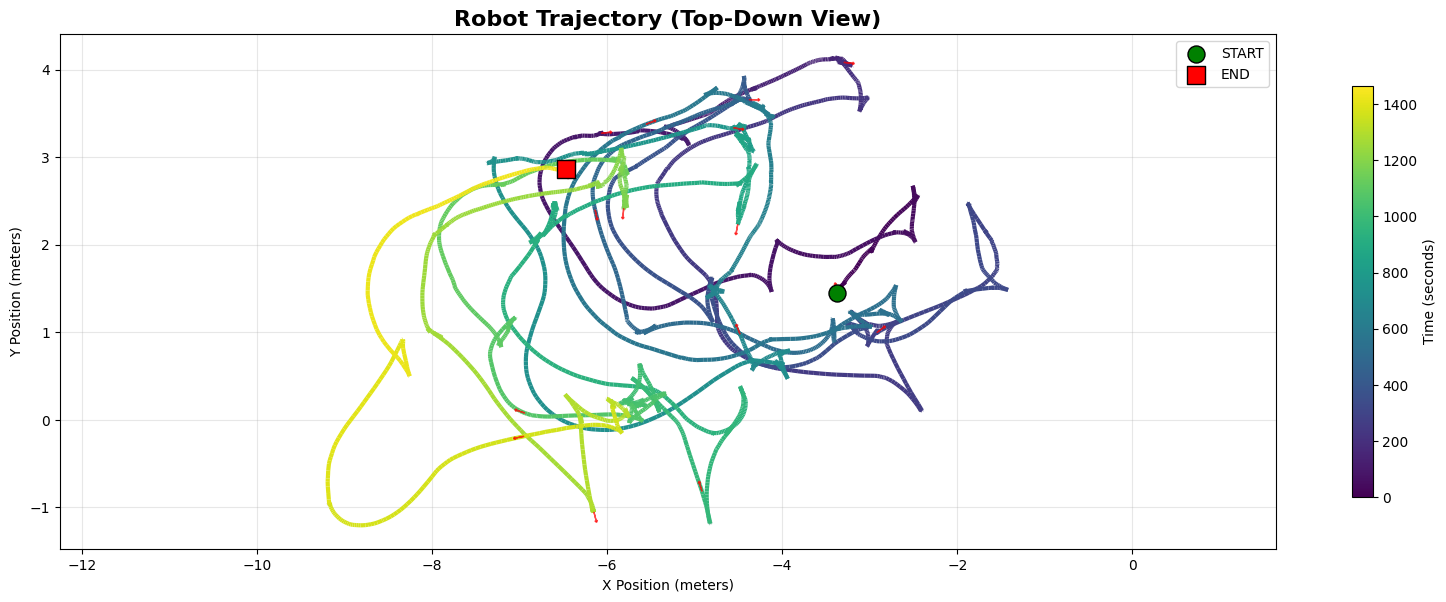

In [32]:
# Visualize trajectory
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
    
    # 1. Main 2D trajectory plot
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=150, marker='o', label='START', zorder=10, edgecolor='black')
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=150, marker='s', label='END', zorder=10, edgecolor='black')
    
    # Add orientation arrows
    N = max(1, len(df) // 15)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.1
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.03, head_length=0.02, 
                 fc='red', ec='red', alpha=0.7, zorder=5)
    
    ax1.set_title('Robot Trajectory (Top-Down View)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Colorbar
    cbar = plt.colorbar(line, ax=ax1, shrink=0.8)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No trajectory data to visualize")

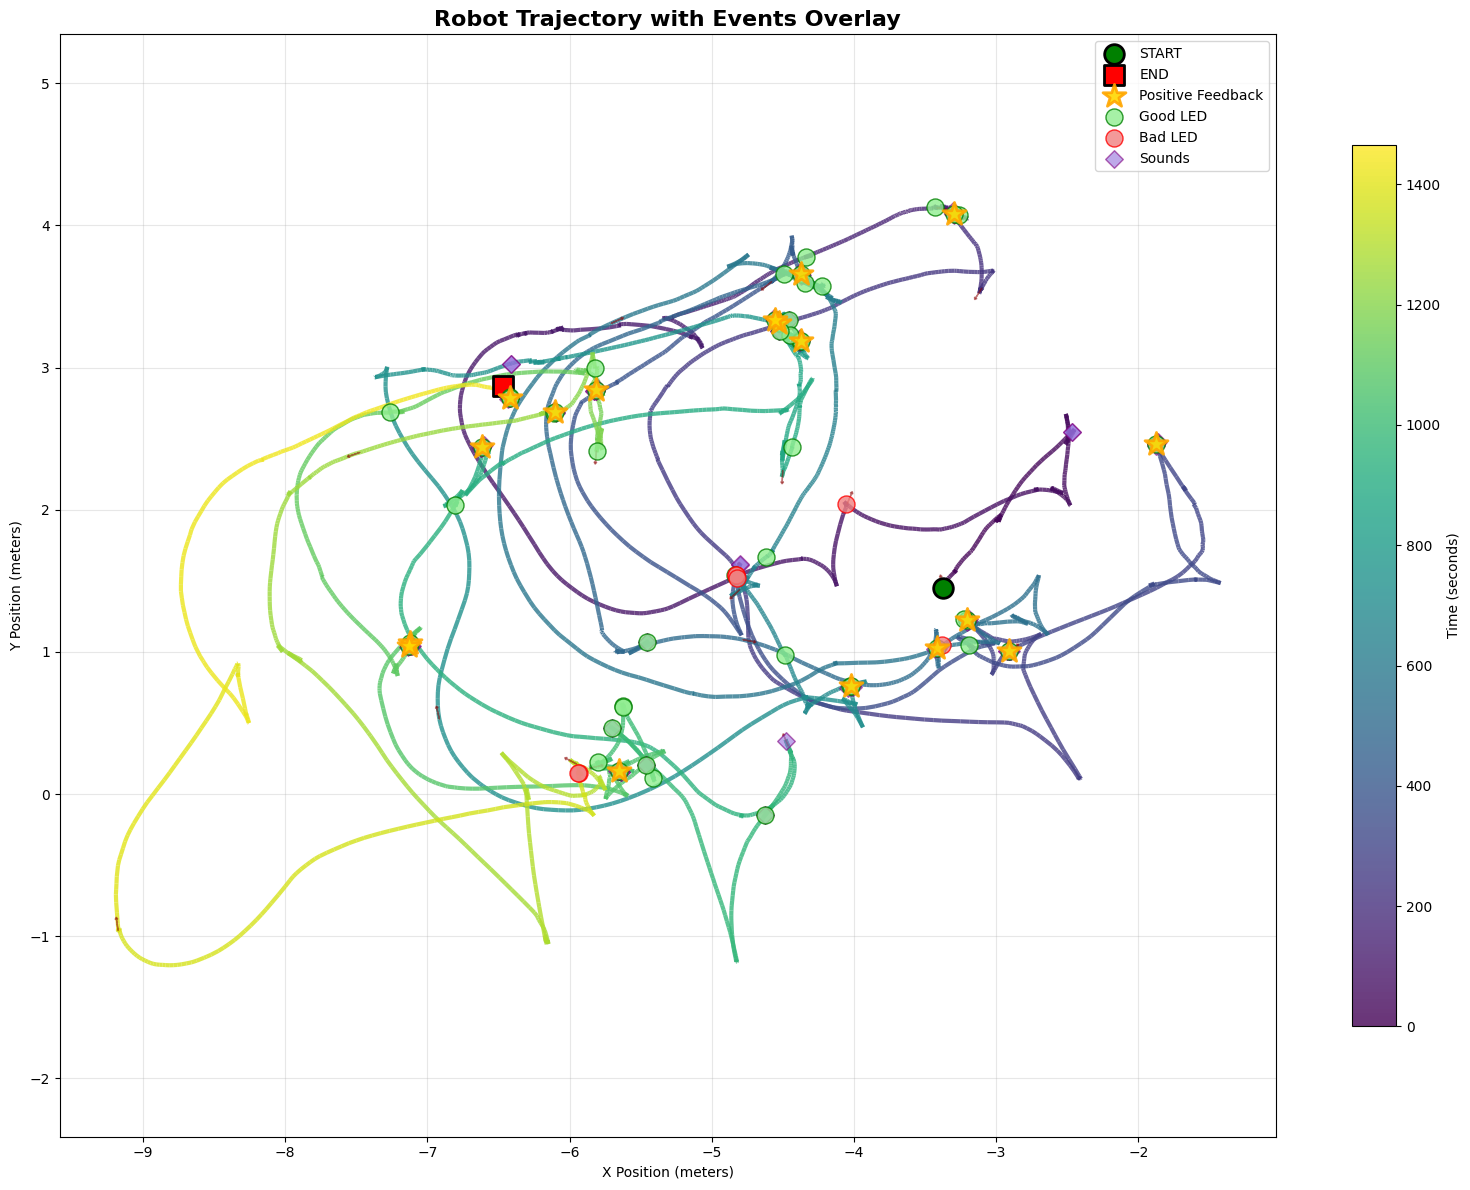

In [33]:
# Enhanced trajectory visualization with events
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Main 2D trajectory plot with events
    ax1 = fig.add_subplot(111)
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3, alpha=0.8)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=200, marker='o', label='START', zorder=10, 
               edgecolor='black', linewidth=2)
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=200, marker='s', label='END', zorder=10, 
               edgecolor='black', linewidth=2)
    
    # Add event markers
    if 'event_positions' in locals() and not event_positions.empty:
        
        # Positive feedback events
        positive = event_positions[event_positions['action'] == 'positive_feedback']
        if len(positive) > 0:
            ax1.scatter(positive['x'], positive['y'], 
                       color='gold', s=300, marker='*', label='Positive Feedback', 
                       zorder=15, edgecolor='orange', linewidth=2, alpha=0.9)
        
        # LED feedback events
        led_feedback = event_positions[event_positions['action'] == 'feedback_blink']
        if len(led_feedback) > 0:
            # Separate good vs bad feedback
            good_led = led_feedback[led_feedback['details'].astype(str).str.contains('good')]
            bad_led = led_feedback[led_feedback['details'].astype(str).str.contains('bad')]
            
            if len(good_led) > 0:
                ax1.scatter(good_led['x'], good_led['y'], 
                           color='lightgreen', s=150, marker='o', label='Good LED', 
                           zorder=12, edgecolor='green', linewidth=1, alpha=0.8)
            if len(bad_led) > 0:
                ax1.scatter(bad_led['x'], bad_led['y'], 
                           color='lightcoral', s=150, marker='o', label='Bad LED', 
                           zorder=12, edgecolor='red', linewidth=1, alpha=0.8)
        
        # Movement events (commented out - too cluttered)
        # movement = event_positions[event_positions['event_type'] == 'movement']
        # if len(movement) > 0:
        #     ax1.scatter(movement['x'], movement['y'], 
        #                color='cyan', s=120, marker='^', label='Movement Events', 
        #                zorder=11, edgecolor='blue', linewidth=1, alpha=0.7)
        
        # Sound events
        sounds = event_positions[event_positions['event_type'] == 'sound_control']
        if len(sounds) > 0:
            ax1.scatter(sounds['x'], sounds['y'], 
                       color='mediumpurple', s=80, marker='D', label='Sounds', 
                       zorder=11, edgecolor='purple', linewidth=1, alpha=0.6)
    
    # Add orientation arrows (fewer to avoid clutter)
    N = max(1, len(df) // 20)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.08
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.02, head_length=0.015, 
                 fc='darkred', ec='darkred', alpha=0.5, zorder=5)
    
    ax1.set_title('Robot Trajectory with Events Overlay', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Legend inside the plot (like in the reference code)
    ax1.legend()
    
    # Colorbar for trajectory time
    cbar = plt.colorbar(line, ax=ax1, shrink=0.8)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No trajectory data to visualize")

In [35]:
# Interactive trajectory visualization with a SIMPLE dual-handle time slider
# Only show GOOD and BAD feedback related events (positive feedback + LED good/bad + explicit negative/bad events)
# Enlarged layout for better visibility.
# Fixed: removed unsupported axis properties (titlefont) & colorbar titlefont/tickfont for this Plotly version.

try:
    import plotly.graph_objects as go
    import numpy as np
    import pandas as pd
    from ipywidgets import FloatRangeSlider, VBox, HTML, HBox, Button, Layout
    from IPython.display import display
    PLOTLY_OK = True
except ImportError as e:
    print("❌ Required libraries missing.")
    print("Install with: pip install plotly ipywidgets")
    PLOTLY_OK = False


def create_time_range_slider_widget(df, event_positions=None, max_points=15000):
    """Return a VBox containing a FigureWidget and a dual-handle time range slider.

    Event display policy:
      - Keep ONLY events that correspond to good/bad feedback signals:
          * action == 'positive_feedback'
          * action contains 'negative' or 'bad'
          * action == 'feedback_blink' whose details contain 'good' or 'bad'
      - All other event types (movement starts, system start, etc.) are suppressed.
    """
    if df.empty:
        return HTML("<b>No data</b>")

    # Optional downsampling for performance
    if len(df) > max_points:
        step = int(np.ceil(len(df) / max_points))
        base_df = df.iloc[::step].copy()
        print(f"⚡ Downsampled from {len(df)} to {len(base_df)} points for interaction speed")
    else:
        base_df = df.copy()

    # Precompute arrays for fast masking
    time_rel = base_df['time_rel'].to_numpy()
    speed = base_df['speed'].to_numpy()
    x_vals = base_df['x'].to_numpy()
    y_vals = base_df['y'].to_numpy()
    yaw_deg_vals = base_df['yaw_deg'].to_numpy()

    fig = go.FigureWidget(layout=dict(
        width=1200,
        height=800,
        title=dict(text='🤖 Robot Trajectory (Time-Windowed)', x=0.5, font=dict(size=22)),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=60, r=40, t=90, b=60),
        # Use simple axis title string & tickfont only (avoid titlefont which errors in this version)
        xaxis=dict(title='X (m)', tickfont=dict(size=12), showgrid=True, gridcolor='lightgray'),
        yaxis=dict(title='Y (m)', tickfont=dict(size=12), showgrid=True, gridcolor='lightgray', scaleanchor='x', scaleratio=1),
        hovermode='closest'
    ))

    full_path = go.Scatter(
        x=x_vals, y=y_vals, mode='lines',
        line=dict(color='rgba(150,150,150,0.30)', width=3),
        name='Full Path', hoverinfo='skip'
    )

    colored_segment = go.Scatter(
        x=x_vals, y=y_vals, mode='lines+markers',
        line=dict(color='rgba(40,90,160,0.85)', width=4),
        marker=dict(
            size=7,
            color=speed,
            colorscale='Plasma',
            showscale=True,
            # Remove unsupported titlefont/tickfont; keep title text only
            colorbar=dict(title='Speed (m/s)', len=0.55)
        ),
        customdata=np.column_stack((time_rel, yaw_deg_vals)),
        hovertemplate=(
            't: %{customdata[0]:.2f}s<br>'
            'X: %{x:.2f} m<br>'
            'Y: %{y:.2f} m<br>'
            'Speed: %{marker.color:.3f} m/s<br>'
            'Heading: %{customdata[1]:.0f}°<extra></extra>'
        ),
        name='Selected Window'
    )

    start_marker = go.Scatter(
        x=[df['x'].iloc[0]], y=[df['y'].iloc[0]],
        mode='markers',
        marker=dict(size=16, color='lime', line=dict(width=3, color='darkgreen')),
        name='Start', hovertemplate='<b>START</b><br>X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'
    )
    end_marker = go.Scatter(
        x=[df['x'].iloc[-1]], y=[df['y'].iloc[-1]],
        mode='markers',
        marker=dict(size=16, color='red', symbol='square', line=dict(width=3, color='darkred')),
        name='End', hovertemplate='<b>END</b><br>X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'
    )

    # Prepare filtered feedback events
    good_times = bad_times = None
    good_x = good_y = bad_x = bad_y = np.array([])

    if event_positions is not None and not event_positions.empty:
        ev = event_positions.copy()
        ev['action_str'] = ev['action'].astype(str).str.lower()
        details_str = ev.get('details', pd.Series([{}]*len(ev))).astype(str).str.lower()

        good_mask = (
            (ev['action_str'] == 'positive_feedback') |
            ((ev['action_str'] == 'feedback_blink') & details_str.str.contains('good'))
        )
        bad_mask = (
            ev['action_str'].str.contains('negative|bad') |
            ((ev['action_str'] == 'feedback_blink') & details_str.str.contains('bad'))
        )

        if good_mask.any():
            good_subset = ev[good_mask]
            good_times = good_subset['event_time'].to_numpy(dtype=float)
            good_x = good_subset['x'].to_numpy()
            good_y = good_subset['y'].to_numpy()
        if bad_mask.any():
            bad_subset = ev[bad_mask]
            bad_times = bad_subset['event_time'].to_numpy(dtype=float)
            bad_x = bad_subset['x'].to_numpy()
            bad_y = bad_subset['y'].to_numpy()

    good_trace = go.Scatter(
        x=[], y=[], mode='markers',
        marker=dict(size=14, color='gold', symbol='star', line=dict(width=2, color='orange')),
        name='Good Feedback',
        hovertemplate='GOOD<br>X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'
    )
    bad_trace = go.Scatter(
        x=[], y=[], mode='markers',
        marker=dict(size=12, color='lightcoral', symbol='x', line=dict(width=2, color='red')),
        name='Bad / Negative',
        hovertemplate='BAD<br>X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'
    )

    fig.add_traces([full_path, colored_segment, start_marker, end_marker, good_trace, bad_trace])

    segment_trace = fig.data[1]
    good_trace_fig = fig.data[4]
    bad_trace_fig = fig.data[5]

    t_min = float(time_rel.min())
    t_max = float(time_rel.max())
    slider = FloatRangeSlider(
        value=(t_min, t_max),
        min=t_min,
        max=t_max,
        step=max((t_max - t_min) / 600.0, 0.01),
        description='Time (s)',
        continuous_update=True,
        layout=Layout(width='1100px')
    )
    stats_label = HTML()

    def update_range(_=None):
        t0, t1 = slider.value
        mask = (time_rel >= t0) & (time_rel <= t1)
        if mask.any():
            segment_trace.x = x_vals[mask]
            segment_trace.y = y_vals[mask]
            segment_trace.marker.color = speed[mask]
            segment_trace.customdata = np.column_stack((time_rel[mask], yaw_deg_vals[mask]))
            dx = np.diff(x_vals[mask]); dy = np.diff(y_vals[mask])
            seg_len = np.sqrt(dx*dx + dy*dy).sum()
            stats_label.value = (
                f"<span style='color:gray; font-size:14px'>Window: {t0:.2f}s – {t1:.2f}s | Points: {mask.sum()} | Path length: {seg_len:.2f} m</span>"
            )
        else:
            segment_trace.x = []
            segment_trace.y = []
            segment_trace.marker.color = []
            segment_trace.customdata = []
            stats_label.value = "<span style='color:gray'>Empty selection</span>"
        if good_times is not None:
            gmask = (good_times >= t0) & (good_times <= t1)
            good_trace_fig.x = good_x[gmask] if gmask.any() else []
            good_trace_fig.y = good_y[gmask] if gmask.any() else []
        if bad_times is not None:
            bmask = (bad_times >= t0) & (bad_times <= t1)
            bad_trace_fig.x = bad_x[bmask] if bmask.any() else []
            bad_trace_fig.y = bad_y[bmask] if bmask.any() else []

    slider.observe(update_range, names='value')
    update_range()

    reset_btn = Button(description='Reset', layout=Layout(width='80px'))
    def do_reset(_):
        slider.value = (t_min, t_max)
    reset_btn.on_click(do_reset)

    header = HTML("<b style='font-size:16px'>Select time window — only GOOD/BAD feedback markers shown.</b>")

    return VBox([header, HBox([slider, reset_btn]), stats_label, fig])


# Display widget if data available
if PLOTLY_OK and 'df' in locals() and not df.empty:
    print("🎯 Building interactive range slider visualization (good/bad feedback only, enlarged)...")
    try:
        widget = create_time_range_slider_widget(df, event_positions if 'event_positions' in locals() else None)
        display(widget)
        print("✅ Ready. Adjust the slider to filter the trajectory by time.")
    except Exception as e:
        print(f"❌ Failed to build widget: {e}")
        print("If ipywidgets is not enabled, run: pip install ipywidgets && jupyter nbextension enable --py widgetsnbextension")
else:
    if not PLOTLY_OK:
        print("⚠️ Plotly/ipywidgets unavailable.")
    else:
        print("❌ No trajectory data available for interactive visualization")

🎯 Building interactive range slider visualization (good/bad feedback only, enlarged)...


✅ Ready. Adjust the slider to filter the trajectory by time.
